## **MMCCI Aging Brain Integration and Analysis Example**

In this example, we have young and aged Visium and STOmics mouse brain samples.
Each sample has been run through stLearn CCI and the outputs are saved as `.h5ad` files.

We will integrate the samples together, and then run analysis on the integrated results.

### **Integration**

These CCI results will be integrated together in this notebook with the following steps:
1. Load the stLearn outputs and convert to be used with MMCCI
2. Integrate within technologies for aged and young
3. Integrate between technologies for aged and young

\
Note: This notebook took <5 mins to run and used <500MB of memory (mostly because of sample loading)

In [1]:
import multimodal_cci as mmcci

2024-05-23 11:58:25.915867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 11:58:26.036997: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 11:58:26.040633: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-23 11:58:26.040654: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc

#### 1. Load stLearn outputs

This data is available on the GitHub repo and includes the `adata.uns['per_lr_cci_cell_type]` for each sample, as well as the number of spots for each sample

In [2]:
import pickle

with open('../data/brain_data.pkl', 'rb') as f:
    brain_data = pickle.load(f)

In [3]:
# These colours will be used for plotting later

from matplotlib import pyplot as plt

colors = {
    'Ependymal': plt.colormaps.get_cmap('tab10').colors[0],
    'Astrocytes': plt.colormaps.get_cmap('tab10').colors[1],
    'Vascular': plt.colormaps.get_cmap('tab10').colors[2],
    'Oligos': plt.colormaps.get_cmap('tab10').colors[3],
    'Neurons': plt.colormaps.get_cmap('tab10').colors[4],
    'Microglia': plt.colormaps.get_cmap('tab10').colors[5],
    'Immune': plt.colormaps.get_cmap('tab10').colors[6],
    'PeripheralGlia': plt.colormaps.get_cmap('tab10').colors[7],
}

#### 2. Integrate within technologies

This step first normalises the samples based on the number of spots, then it integrates the LR matrices together per LR pair

In [4]:
brain_aged_tech1_normalised = mmcci.it.normalise_within_tech(brain_data['brain_aged_tech1_cci'], brain_data['brain_aged_tech1_sizes'])
brain_young_tech1_normalised = mmcci.it.normalise_within_tech(brain_data['brain_young_tech1_cci'], brain_data['brain_young_tech1_sizes'])
brain_aged_tech2_normalised = mmcci.it.normalise_within_tech(brain_data['brain_aged_tech2_cci'], brain_data['brain_aged_tech2_sizes'])
brain_young_tech2_normalised = mmcci.it.normalise_within_tech(brain_data['brain_young_tech2_cci'], brain_data['brain_young_tech2_sizes'])

brain_aged_tech1_integrated = mmcci.it.integrate_samples(brain_aged_tech1_normalised, method=">50%")
brain_young_tech1_integrated = mmcci.it.integrate_samples(brain_young_tech1_normalised, method=">50%")
brain_aged_tech2_integrated = mmcci.it.integrate_samples(brain_aged_tech2_normalised, method=">50%")
brain_young_tech2_integrated = mmcci.it.integrate_samples(brain_young_tech2_normalised, method=">50%")

The next step involves integrating the p-values together

In [5]:
brain_aged_tech1_pvals = mmcci.it.integrate_p_vals(brain_data['brain_aged_tech1_pvals'])
brain_young_tech1_pvals = mmcci.it.integrate_p_vals(brain_data['brain_young_tech1_pvals'])
brain_aged_tech2_pvals = mmcci.it.integrate_p_vals(brain_data['brain_aged_tech2_pvals'])
brain_young_tech2_pvals = mmcci.it.integrate_p_vals(brain_data['brain_young_tech2_pvals'])

Then we remove the statistically insignificant interactions

In [6]:
brain_aged_tech1_integrated_filtered = mmcci.it.remove_insignificant(brain_aged_tech1_integrated, brain_aged_tech1_pvals)
brain_young_tech1_integrated_filtered = mmcci.it.remove_insignificant(brain_young_tech1_integrated, brain_young_tech1_pvals)
brain_aged_tech2_integrated_filtered = mmcci.it.remove_insignificant(brain_aged_tech2_integrated, brain_aged_tech2_pvals)
brain_young_tech2_integrated_filtered = mmcci.it.remove_insignificant(brain_young_tech2_integrated, brain_young_tech2_pvals)

#### 3. Integrate between technologies

This step first normalises the samples based on the number of interactions, then it integrates the LR matrices together per LR pair

In [7]:
aged_normalised = mmcci.it.normalise_between_tech([brain_aged_tech1_integrated, brain_aged_tech2_integrated])
young_normalised = mmcci.it.normalise_between_tech([brain_young_tech1_integrated, brain_young_tech2_integrated])

aged_integrated = mmcci.it.integrate_samples(aged_normalised)
young_integrated = mmcci.it.integrate_samples(young_normalised)

Again, we integrate the p-values, this time across all the samples. Then we remove the insignificant interactions

In [8]:
aged_pvals = mmcci.it.integrate_p_vals(brain_data['brain_aged_tech1_pvals'] + brain_data['brain_aged_tech2_pvals'])
young_pvals = mmcci.it.integrate_p_vals(brain_data['brain_young_tech1_pvals'] + brain_data['brain_young_tech2_pvals'])

aged_integrated = mmcci.it.remove_insignificant(aged_integrated, aged_pvals)
young_integrated = mmcci.it.remove_insignificant(young_integrated, young_pvals)

Now we can visualise our integrated samples, either as network plots or chord plots

In [9]:
aged_overall = mmcci.it.calculate_overall_interactions(aged_integrated)
young_overall = mmcci.it.calculate_overall_interactions(young_integrated)

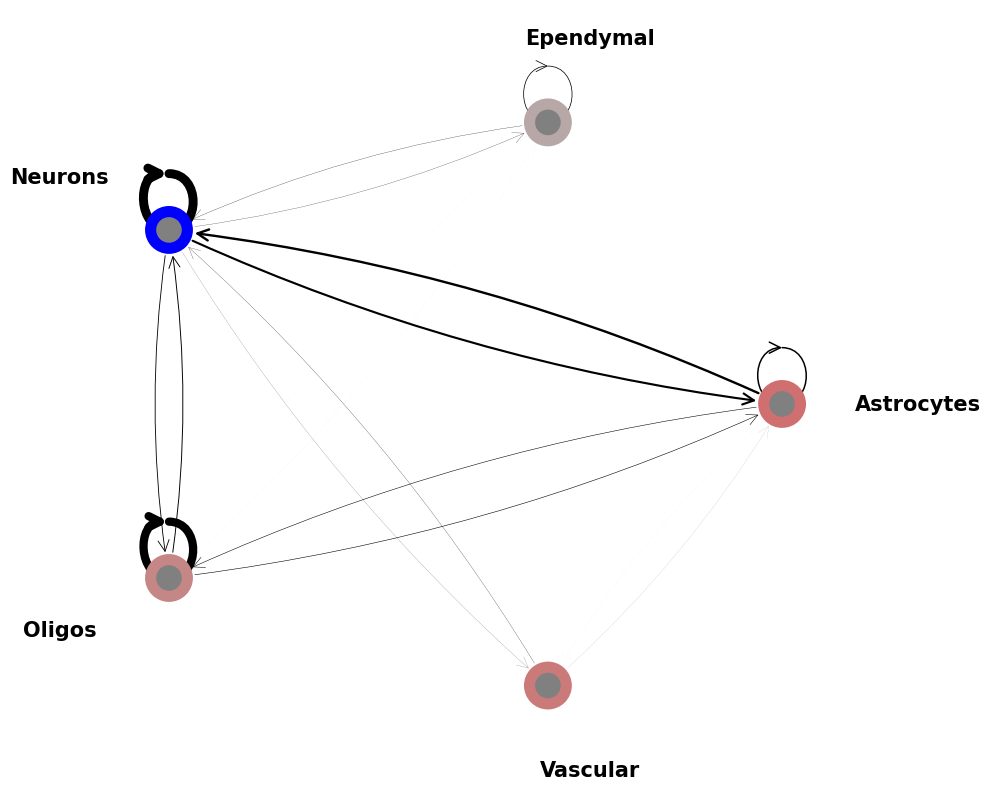

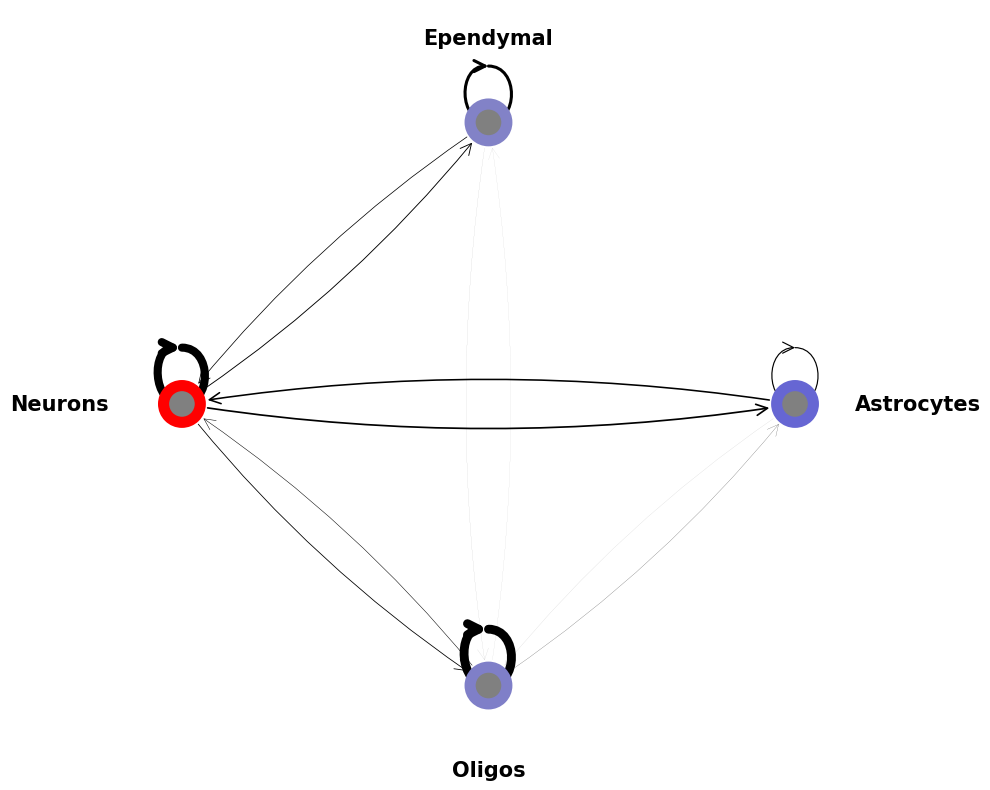

In [10]:
# Network plots
mmcci.plt.network_plot(aged_overall)
mmcci.plt.network_plot(young_overall)

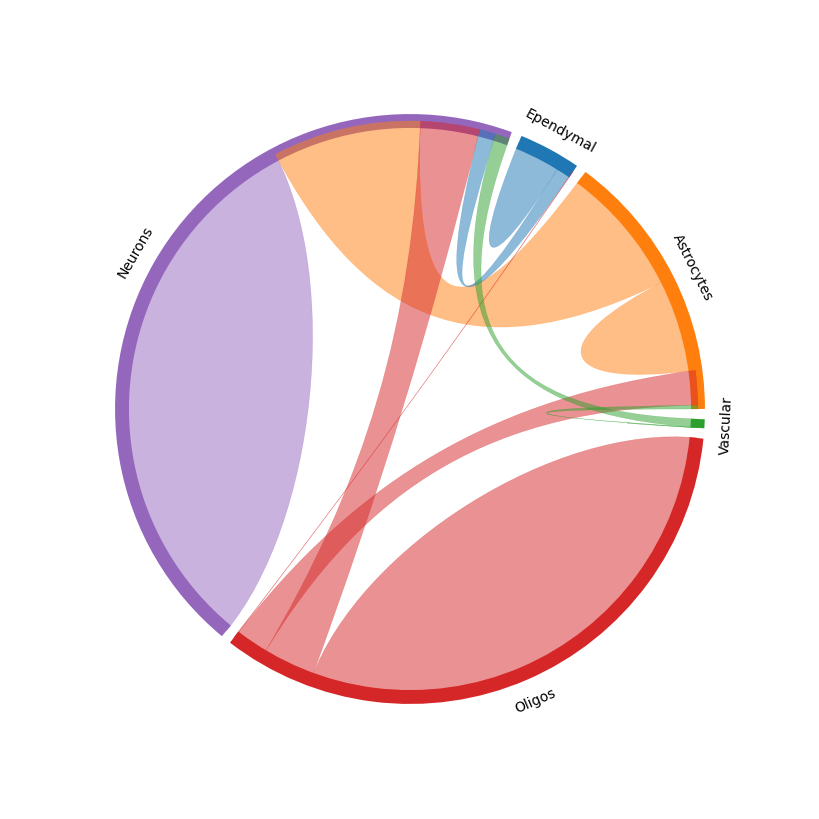

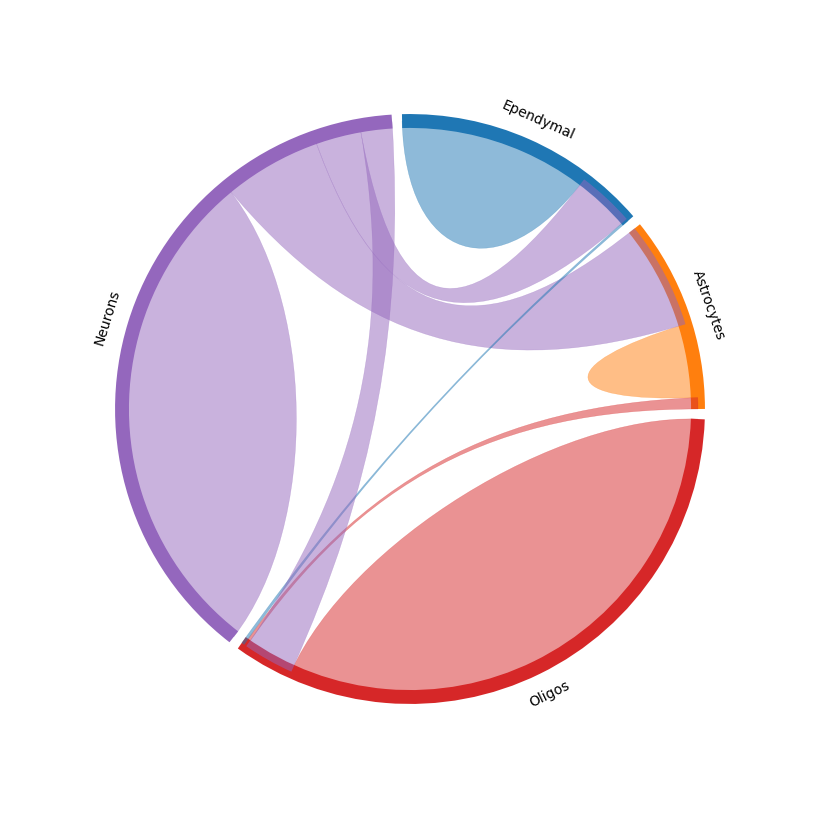

In [11]:
# Chord plots
mmcci.plt.chord_plot(aged_overall, colors=colors)
mmcci.plt.chord_plot(young_overall, colors=colors)

## **Analysis**

Now there are many analyses we can run on our integrated samples such as:
1. Get a difference plot between groups with permutation testing
2. Find dissimilar LR pairs
3. Query network edges for LR pairs
4. LR network clustering
5. LR interaction clustering

#### 1. Calculate p values for significance changes between aged and young overall networks

In [12]:
p_values = mmcci.an.perm_test(aged_overall, young_overall)
p_values

,Astrocytes,Ependymal,Immune,Microglia,Neurons,Oligos,PeripheralGlia,Vascular
Astrocytes,0.15734,0.28111,0.28197,0.28342,0.03050,0.07797,0.27941,0.26498
Ependymal,0.28276,0.00000,0.28077,0.28135,0.09358,0.23510,0.28001,0.28274
Immune,0.28119,0.28013,0.28327,0.28143,0.28230,0.27956,0.28368,0.28171
Microglia,0.27935,0.28125,0.27903,0.27956,0.28177,0.28228,0.28000,0.27995
Neurons,0.12426,0.04560,0.28436,0.28262,0.01539,0.22204,0.28200,0.18861
Oligos,0.14063,0.24967,0.27972,0.28131,0.10894,0.06206,0.27967,0.28119
PeripheralGlia,0.28034,0.27985,0.27919,0.28093,0.28158,0.28110,0.28220,0.28097
Vascular,0.20486,0.28128,0.28315,0.28019,0.17142,0.27865,0.28020,0.27970


Now we can plot the difference plot. \
\
Purple edges are significantly increased in aged and green are significantly increased in young

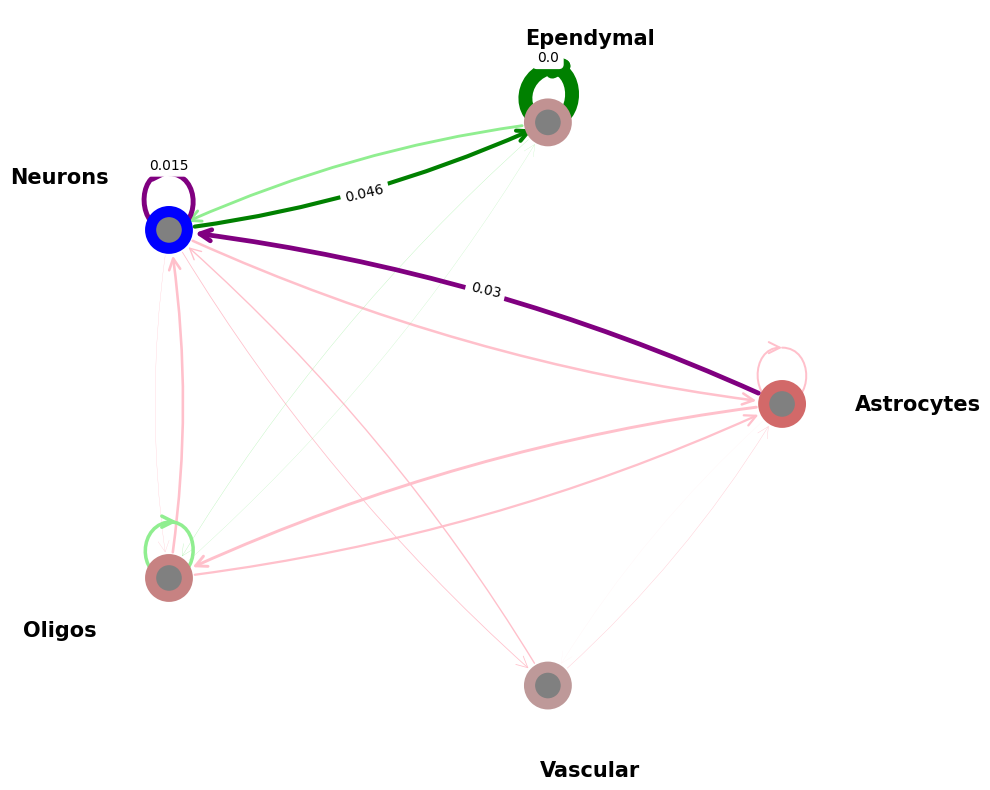

In [13]:
age_diff = mmcci.an.get_network_diff(aged_overall, young_overall)
mmcci.plt.network_plot(age_diff, p_values, diff_plot=True, edge_weight=120)

#### 2. Find LR pairs with dissimilar networks between aged and young 

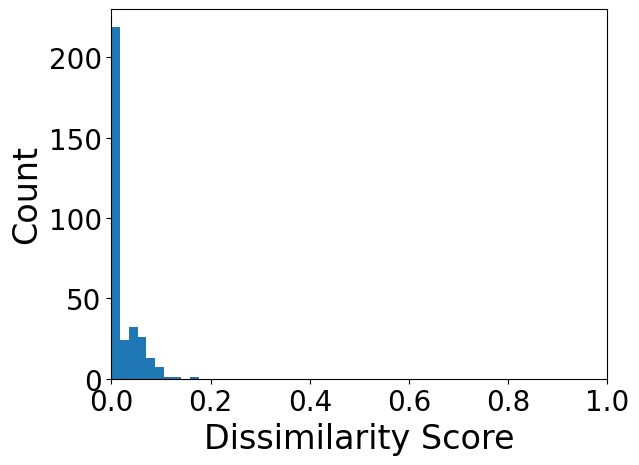

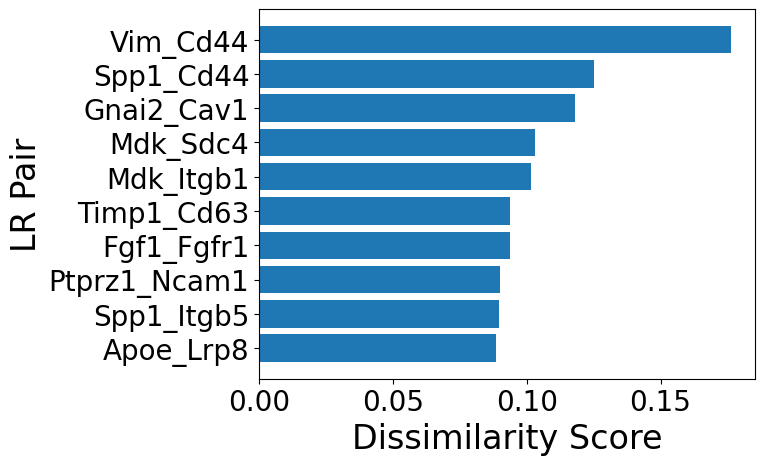

In [14]:
# Calculate dissimilarity score between aged and young for every LR pair 
dissimilarity_scores = mmcci.an.calculate_dissim(aged_integrated, young_integrated)

# Plot a histogram of these scores to see how much the LR networks change
mmcci.plt.dissim_hist(dissimilarity_scores)

# Show the most dissimilar LR pairs
mmcci.plt.lr_top_dissimilarity(dissimilarity_scores)

We can plot the most dissimilar LR pair to see how it changes. \
\
We can run a permutation test between the groups and plot the difference plot. \
The purple edges are more present in aged and the green edges are more present in young.

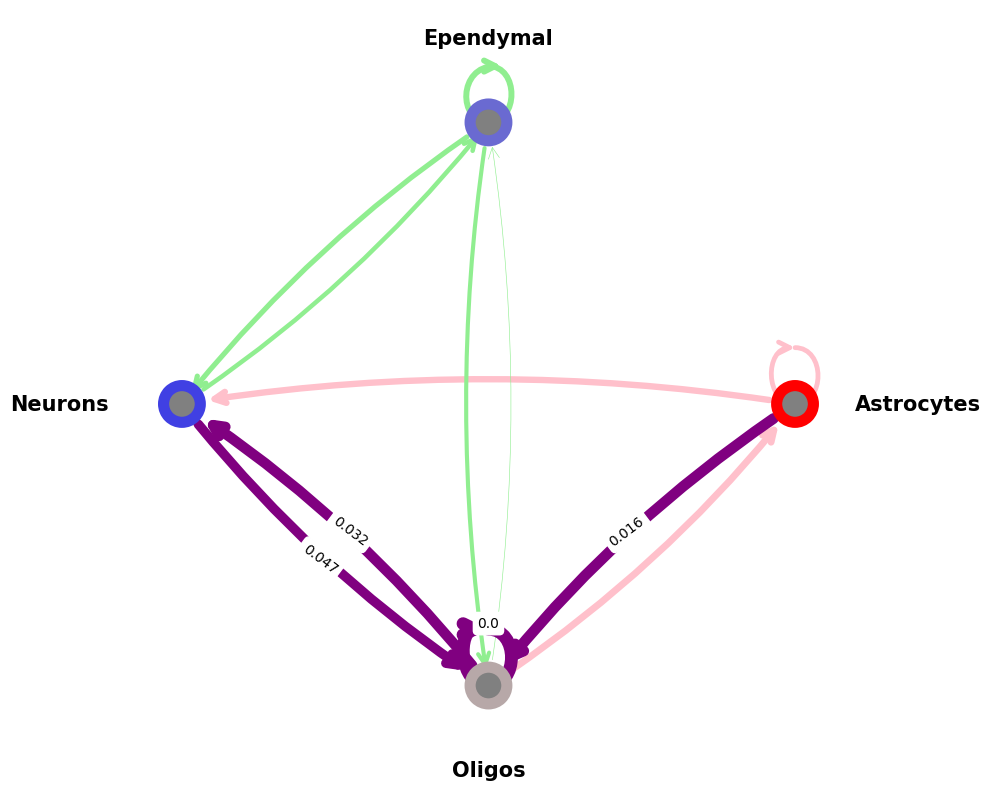

In [15]:
age_diff = mmcci.an.get_network_diff(aged_integrated['Vim_Cd44'], young_integrated['Vim_Cd44'])
p_values = mmcci.an.perm_test(aged_integrated['Vim_Cd44'], young_integrated['Vim_Cd44'])
mmcci.plt.network_plot(age_diff, p_values, diff_plot=True, edge_weight=0.1)

#### 3. Get LR pairs from a sender (Astrocytes) and reciever (Neurons) cell type pair

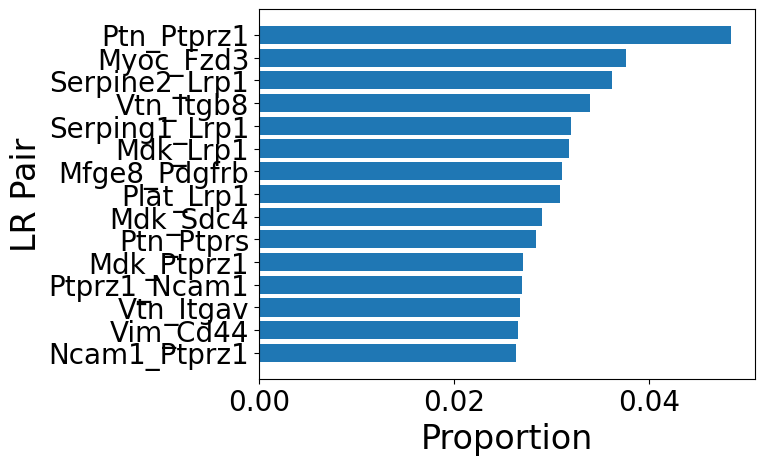

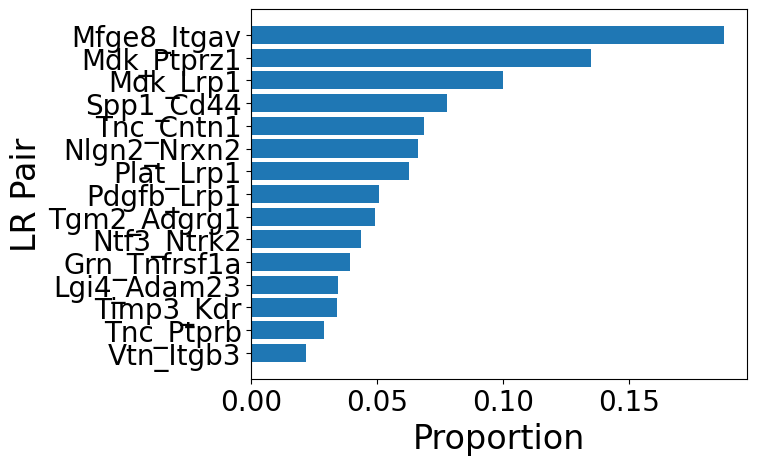

In [16]:
# Aged
mmcci.plt.lrs_per_celltype(aged_integrated, sender="Astrocytes", receiver="Neurons")

# Young
mmcci.plt.lrs_per_celltype(young_integrated, sender="Astrocytes", receiver="Neurons")

#### 4. Run LR network clustering

This analysis clusters LR pairs with similar networks together. \
Here we show an example of one aged cluster and one young cluster and run GSEA analysis on the LRs involved

Computing Dissimilarity Scores for multiple interactions...


Processing: 100%|██████████| 149/149 [00:07<00:00, 18.86it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...
Computing Dissimilarity Scores for single interactions...


Processing: 100%|██████████| 156/156 [00:09<00:00, 15.64it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...

cluster0: Contains 24 LR pairs


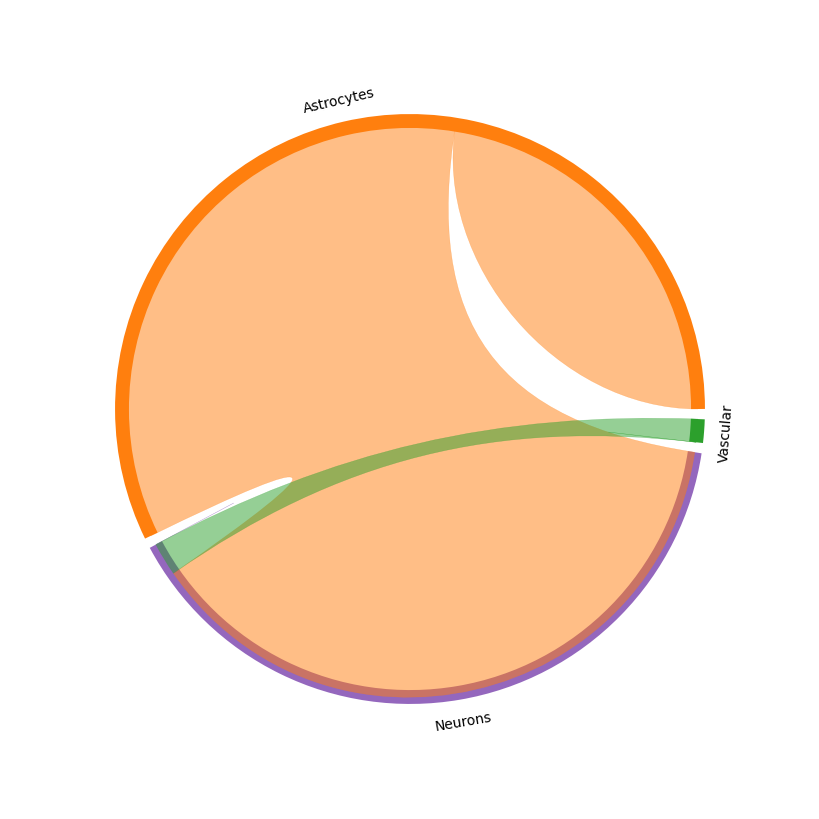

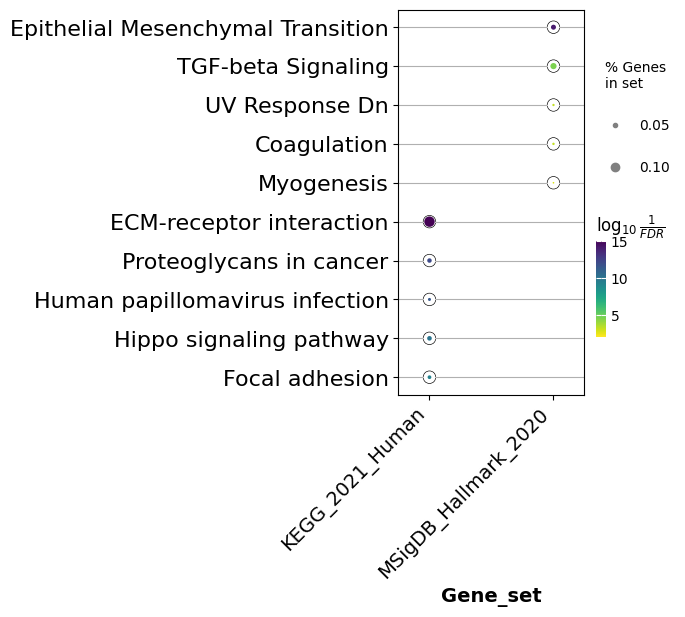

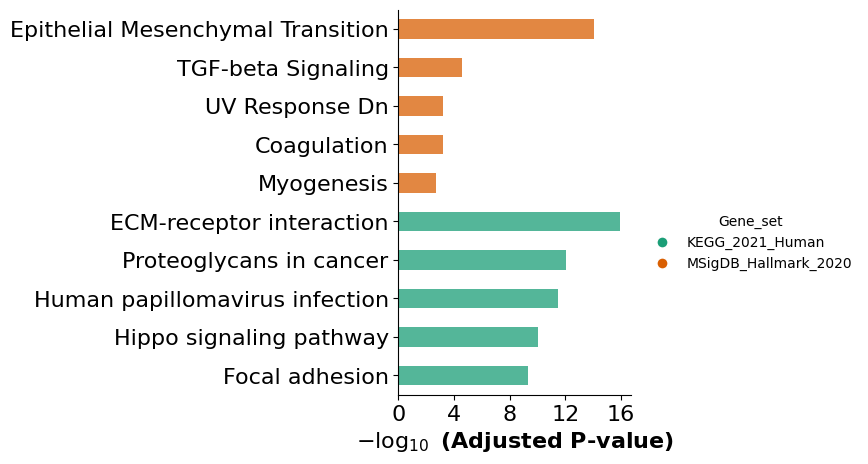

In [17]:
aged_clusters = mmcci.an.lr_grouping(aged_integrated, n_clusters=0)
aged_integrated_clusters = mmcci.an.subset_clusters(aged_integrated, aged_clusters)
aged_overall_clusters = mmcci.an.calculate_cluster_interactions(aged_integrated_clusters)

for cluster, matrix in list(aged_overall_clusters.items())[0:1]:
    print("\ncluster" + str(cluster) + ": Contains " + str(len(aged_integrated_clusters[cluster])) + " LR pairs")
    mmcci.plt.chord_plot(matrix, colors=colors)
    mmcci.an.run_gsea(aged_integrated_clusters[cluster], organism="mouse", gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"])

Computing Dissimilarity Scores for multiple interactions...


Processing: 100%|██████████| 65/65 [00:01<00:00, 42.06it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...
Computing Dissimilarity Scores for single interactions...


Processing: 100%|██████████| 104/104 [00:04<00:00, 25.55it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...

cluster0: Contains 43 LR pairs


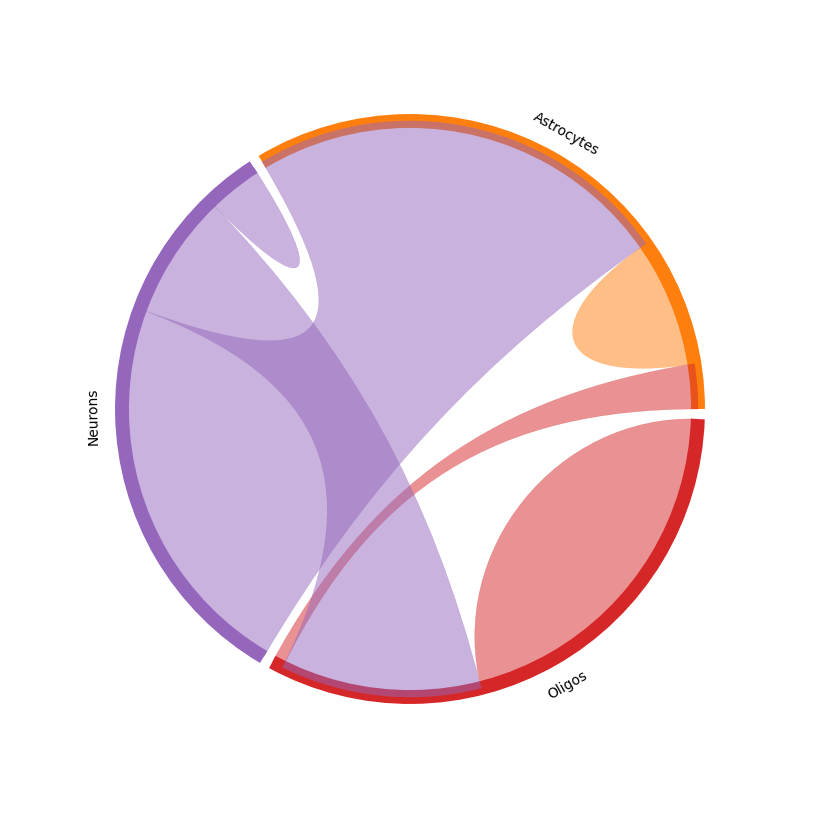

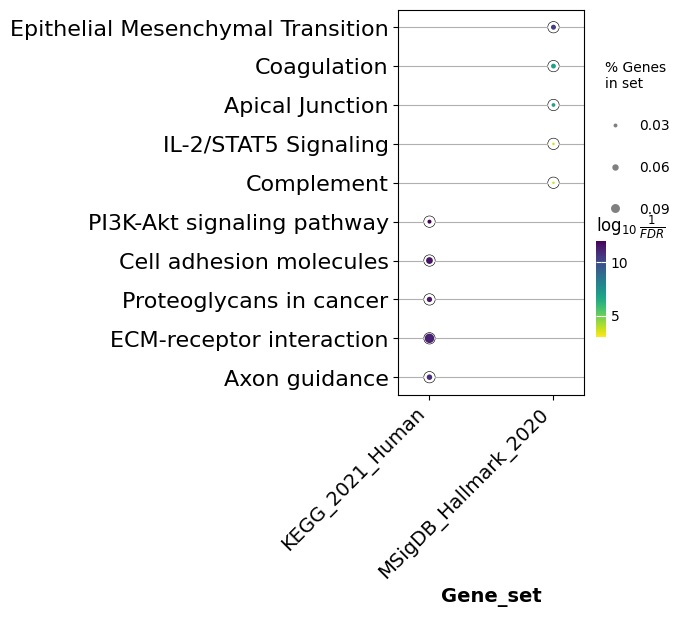

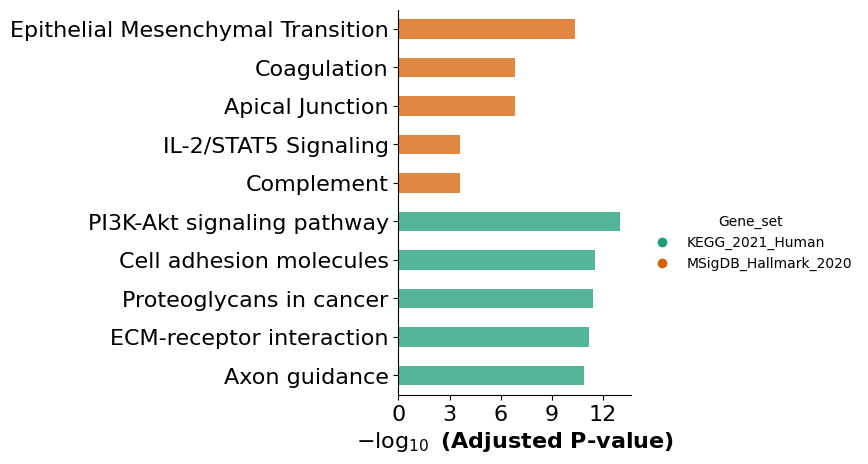

In [18]:
young_clusters = mmcci.an.lr_grouping(young_integrated, n_clusters=0)
young_integrated_clusters = mmcci.an.subset_clusters(young_integrated, young_clusters)
young_overall_clusters = mmcci.an.calculate_cluster_interactions(young_integrated_clusters)
        
for cluster, matrix in list(young_overall_clusters.items())[0:1]:
    print("\ncluster" + str(cluster) + ": Contains " + str(len(young_integrated_clusters[cluster])) + " LR pairs")
    mmcci.plt.chord_plot(matrix, colors=colors)
    mmcci.an.run_gsea(young_integrated_clusters[cluster], organism="mouse", gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"])

#### 5. Run LR interaction clustering

This analysis requires an AnnData sample that has been processed through stLearn as input. It will cluster spots together with similar LR interaction scores.
Here we show an example one sample (not included in data files).

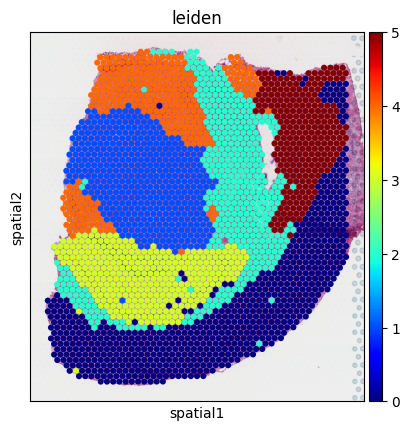

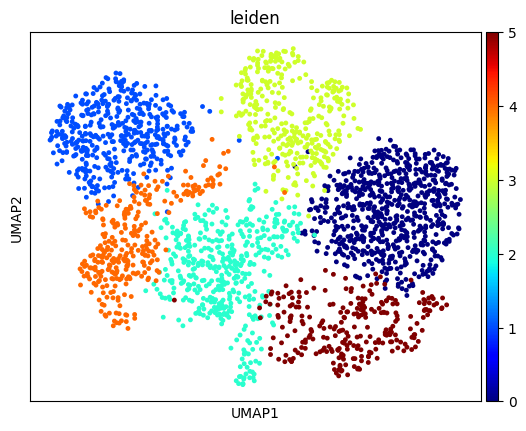

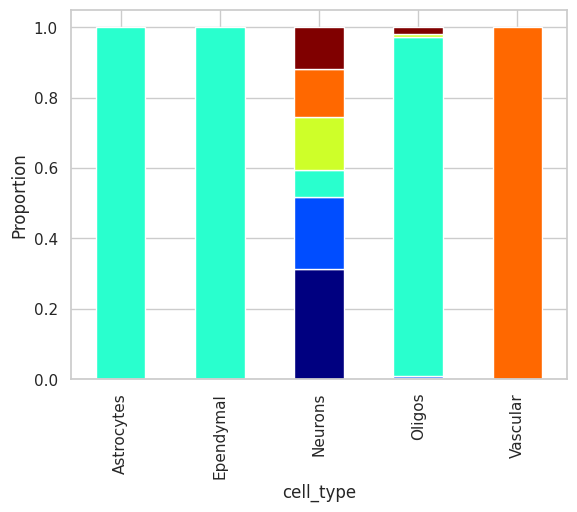

In [20]:
mmcci.an.lr_interaction_clustering(brain_anndata_sample, clustering="leiden")